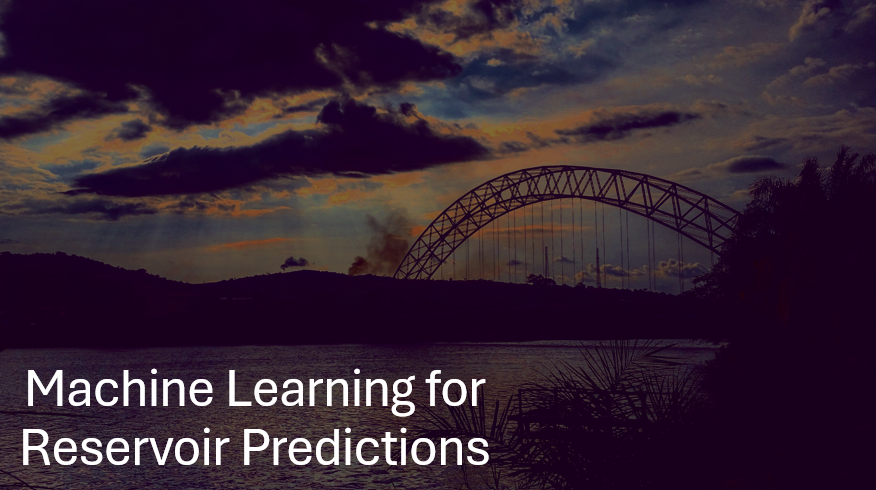

In [ ]:
# install a hydrometrics package
!pip install hydroeval

In [23]:
# import required packages

# standard scientific packages
import numpy as np
import pandas as pd
import datetime as dt

# plotting packages
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn as sns

# various metrics
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import hydroeval as he

# ML packages (see https://scikit-learn.org/stable/api/sklearn.ensemble.html for more info)
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor


# Data selection

The first step in a machine-learning approach is to decide what your target feature will be, and what explanatory features you are going to include. In this walk through, our target feature is **reservoir storage**, and our explanatory features are **precipitation and temperature** over the catchment, as well as **historical storage** and **time of year**.

The model might benefit from other explanatory features, for example estimates of water demand, estimates of inflow, or other climate factors, but we're keeping things simple for this example.

Start by opening and visualising the target feature (reservoir storage as a percentage of total capacity), and the explanatory features (precipitation and temperature over the reservoir catchment) for the Vaal reservoir in South Africa.

In [25]:
# fetch the data from github
%%capture
!wget https://raw.githubusercontent.com/NERC-CEH/ghana_hydro_training_2026/refs/heads/main/Day2_Water_Resources_Modelling/data.zip


In [ ]:
# now unzip data.zip
%%capture
!unzip data.zip # unzip folder

In [ ]:
# open the data for the Vaal reservoir
data = pd.read_csv('data/C1R001_GH.csv')
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')
data = data.set_index('date')
data = data.sort_index()
data

In [ ]:
# Plot reservoir storage, and catchment precipitation and temperature
fig, ax = plt.subplots(figsize=(12,3))
data.storage.plot()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel(r'storage (%)',fontsize=13)
plt.xlabel('')
plt.show()

fig, ax = plt.subplots(figsize=(12,3))
plt.xlim([data.index.min(),data.index.max()])
plt.bar(data.index, data.precipitation, width=20, color='slategrey')
plt.ylabel('precipitation (mm)',fontsize=13)
plt.show()

fig, ax = plt.subplots(figsize=(12,3))
data.temperature.plot(color='chocolate')
plt.ylabel(r'temperature ($\degree$C)',fontsize=13)
plt.xlabel('')
plt.show();

🤔**Questions**

 - What data do you think will be important for the model?

 - What additional datasets do you think would be useful for the model?


# Feature Engineering

Since tree models are not native timeseries models (unlike, for instance, LSTMs) we need to produce lagged variables (i.e. reservoir storage for the previous 1, 2, 3 months etc.) to use as explanatory features. Here we also produce some rolling mean values for the precipitation and temperature, as well as long-term mean storage for a given month. Finally, we convert the date to a cyclical input, so the model knows what time of year it is.

If you're feeling ambitious, try creating your own features here.

Since we're dealing with timeseries data, be careful not to let future information "leak" into the past. For example, the long-term mean storage is updated each year instead of being calculated on the whole timeseries.

In [ ]:
# Function to create lagged features for storage - note this shortens the timeseries data by the number of lags
def res_s_lag(df):
    for i in range(1,7):
        nm = 'storage'+str(i)
        df.loc[:, nm] = df.loc[:, 'storage'].shift(i)
    # Create updating mean months
    mean_month=[np.nan]*12
    for year in range(df.index.min().year,df.index.max().year+1):
        tmp = df[df.index.year <= year]
        tt = tmp.groupby('month').storage.mean()
        for val in tt:
            mean_month.append(val)
    df['mean_month'] = mean_month[:df.shape[0]]
    return df

# Function to create lagged features for precipitation and temperature
def res_ext_lag(df):
    for var in ['precipitation','temperature']:
        for i in range(1,7):
            nm = var+str(i)
            df[nm] = df[var].shift(i)
    # mean precipitation over the last 3, 6 and 12 months
    df['precip_quart'] = df['precipitation'].rolling(window =3).mean()
    df['precip_half'] = df['precipitation'].rolling(window =6).mean()
    df['precip_yr'] = df['precipitation'].rolling(window =12).mean()
    # mean temperature over the last 3, 6 and 12 months
    df['temp_quart'] = df['temperature'].rolling(window =3).mean()
    df['temp_half'] = df['temperature'].rolling(window =6).mean()
    df['temp_yr'] = df['temperature'].rolling(window =12).mean()
    return df


In [ ]:
# create lags and averages for storage, precipitation and temperature
data['month'] = data.index.month
data = res_s_lag(data)
data = res_ext_lag(data)
data = data.dropna()
# create cyclic date variables
data['datesin'] = data.month.apply(lambda x: np.sin(x*2.*np.pi/12))
data['datecos'] = data.month.apply(lambda x: np.cos(x*2.*np.pi/12))
data = data.drop(columns=['month'])

In [ ]:
# now we can inspect the explanatory features that we have
data.columns.to_list()

In [ ]:
# this is also a good time to split our data into training, validation and testing sets
# since we have a timeseries, we'll split the dataset by date into 70:15:15 chunks
# we also split the explanatory features (_X) and target feature (_y)
training = data.iloc[0:int(0.7*len(data))]
training_X, training_y = training.drop(columns='storage'), training['storage']
validation = data.iloc[int(0.7*len(data)):int(0.85*len(data))]
validation_X, validation_y = validation.drop(columns='storage'), validation['storage']
testing = data.iloc[int(0.85*len(data)):]
testing_X, testing_y = testing.drop(columns='storage'), testing['storage']


🤔**Questions**

 - Which features do you think will be important for the model?

 - What additional features do you think would be useful for the model?

 - Do you think different reservoirs will find different features more or less useful? Why might this be?

# Model selection

Here we import and train the model, and see how it performs on our validation data. In this example we only explore one model (Random Forest), but it's relatively easy to swap it out for similar models. Testing different models is a good idea since it's hard to know ahead of time which model structure will perform the best for your particular problem - there will be a chance to explore this later.




In [ ]:
# here we select our model and train it on our data using the default hyperparameters
model = RandomForestRegressor(random_state=345)
model.fit(training_X,training_y)

In [ ]:
# define a set of performance metrics
def eval_reses(obs,pred):
    mae = mean_absolute_error(obs, pred)
    rmse = root_mean_squared_error(obs, pred)
    r2 = r2_score(obs, pred)
    kge = he.evaluator(he.kge, pred, obs)
    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'kge':kge[0][0]}

In [ ]:
# compare the model predictions for the training and validation data, against a benchmark persistence model
runs = {
    'Model train': (model.predict(training_X), training_y),
    'Model validate': (model.predict(validation_X), validation_y),
    'Benchmark train': (training_X['storage1'], training_y),
    'Benchmark validate': (validation_X['storage1'], validation_y)
}
df_results = (pd.DataFrame.from_dict(
          {name: eval_reses(obs, pred) for name, (obs, pred) in runs.items()}
          ))

# print the results
df_results.round(3)

In [ ]:
# plot the predictions against the observed storage
# the training and validation data is included, with a grey demarcation line
obs = pd.concat([training_y,validation_y])
x_axis = obs.index
pred = np.concat([model.predict(training_X),model.predict(validation_X)])

fig, ax = plt.subplots(figsize=(12,3))
plt.plot(x_axis, obs, label='observed')
plt.plot(x_axis, pred, linestyle='--', label='model')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.axvline(validation_y.index.min(),color='grey',linewidth=1)
plt.ylabel(r'storage (%)',fontsize=13)
plt.xlabel('')
plt.show()

In [ ]:
# plotting just the validation data
obs = validation_y
x_axis = obs.index
pred = model.predict(validation_X)

fig, ax = plt.subplots(figsize=(6,3))
plt.plot(x_axis, obs, label='observed')
plt.plot(x_axis, pred, linestyle='--', label='model')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel(r'storage (%)',fontsize=13)
plt.xlabel('')
plt.show()

Although the metrics look good, it is worth noting that a very simple benchmark model also has metrics that are nearly as good, and from the plot of the validation data it is clear that the timing of the model can be slightly off.

The model does very well during the training period - this may indicate some overfitting to the training data that could be addressed by varying the model hyperparameters.

🤔**Questions**

 - Do you think some reservoirs would be easier to model compared to others? Why might this be the case?

 - What features of a reservoir might make them more or less predictable?

 - Would other types of model be better at predicting reservoir storage?

 - What are some of the pros and cons of using an ensemble-tree model?

# Feature Selection

In this section you will explore how selecting different features for our model yields different results. Generally, removing unnecessary features reduces noise and improves performance.

We can make use of the inbuilt **feature importance** method to help us choose which features to keep and which to discard, and inspect the feature **correlations**. If you are feeling ambitious, try returning to the feature engineering section and creating your own features.

_In this section you will need to edit the code before running it._

In [ ]:
# calculate and display the feature importance for all features
feature_importance = list(zip(training_X.columns, model.feature_importances_))
df_feature_importance = pd.DataFrame(feature_importance, columns=['Feature', 'Importance']).set_index('Feature')
df_feature_importance.sort_values(by='Importance',ascending=False).round(3)

Here we can see that the most important feature is the previous month's storage, with the second most important being the previous month's precipitation. This makes sense physically, and explains why the simple persistance benchmark model performs so well. We could try removing the features with the lowest feature importance and seeing how this impacts model results.

Another useful piece of information when undertaking feature selection is how correlated your explanatory features are. To do this we create a correlation matrix of all the features.

In [ ]:
# reorder the data columns for better visualisation
df = data.copy()
prefixes = ('storage', 'precip', 'temp')
grouped_cols = [col for p in prefixes for col in df.columns if col.startswith(p)]
df = df[grouped_cols + [c for c in df.columns if c not in grouped_cols]]

# create & plot correlation matrix
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(20, 230, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


From this we can see that temperature and precipitation are closely correlated along all the lags - so potentially we could remove temperature entirely as a feature set and see if this impacts model performance.

In the code below, try removing some of the features and training your model to see how the performance changes. Try different combinations and record which feature set gives the best model performance (on the validation data) on the shared space.

In [ ]:
# copy the original dataset and remove selected columns
# here is an example where several temperature lags have been removed: data_FS = data.copy().drop(columns = ['temperature3','temperature4','temperature5','temperature6'])

data_FS = data.copy().drop(columns = ) # !! edit this line !!


# split the new data into training, validation and testing periods
training_FS = data_FS.iloc[0:int(0.7*len(data_FS))]
training_FS_X, training_FS_y = training_FS.drop(columns='storage'), training_FS['storage']
validation_FS = data_FS.iloc[int(0.7*len(data_FS)):int(0.85*len(data_FS))]
validation_FS_X, validation_FS_y = validation_FS.drop(columns='storage'), validation_FS['storage']
testing_FS = data_FS.iloc[int(0.85*len(data_FS)):]
testing_FS_X, testing_FS_y = testing_FS.drop(columns='storage'), testing_FS['storage']

# train the model
model_FS = RandomForestRegressor(random_state=345)
model_FS.fit(training_FS_X,training_FS_y)

# compare the new and old model predictions for the training and validation data, against a benchmark persistence model
runs = {
    'New Model train': (model_FS.predict(training_FS_X), training_FS_y),
    'New Model validate': (model_FS.predict(validation_FS_X), validation_FS_y),
    'Model train': (model.predict(training_X), training_y),
    'Model validate': (model.predict(validation_X), validation_y),
    'Benchmark train': (training_X['storage1'], training_y),
    'Benchmark validate': (validation_X['storage1'], validation_y)
}
df_results = (pd.DataFrame.from_dict(
          {name: eval_reses(obs, pred) for name, (obs, pred) in runs.items()}
          ))

# print the results
df_results.round(3)

In [ ]:
# re-examine the feature importance
feature_importance = list(zip(training_FS_X.columns, model_FS.feature_importances_))
df_feature_importance = pd.DataFrame(feature_importance, columns=['Feature', 'Importance']).set_index('Feature')
df_feature_importance.sort_values(by='Importance',ascending=False).round(3)

In [ ]:
# plotting the new results against the original model
obs = validation_y
x_axis = obs.index
pred_o = model.predict(validation_X)
pred_n = model_FS.predict(validation_FS_X)

fig, ax = plt.subplots(figsize=(6,3))
plt.plot(x_axis, obs, label='observed')
plt.plot(x_axis, pred_o, linestyle='--', label='original model')
plt.plot(x_axis, pred_n, linestyle=':', label='new model')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel(r'storage (%)',fontsize=13)
plt.xlabel('')
#plt.savefig('validation_FS.png', dpi=100,bbox_inches='tight') #un-comment this line if you want to save the plot to file
plt.show()

🤔**Questions**

 - Which features turned out to be important for this model and reservoir?

 - Does this seem sensible?

 - Have you noticed any trends while implementing feature selection?
</div>


# Hyperparameter Tuning

Each of the ML models has its own set of parameters, known as hyperparameters, which affect how the model is built. To understand these it is useful to refer back to the model diagrams (below), and to the model documentation page: https://scikit-learn.org/stable/api/sklearn.ensemble.html.

Hyperparameters can be used to improve model performance, but also to reduce the risk of overfitting to the training data.

Here we will explore a subset of the hyperparameters for the Random Forest model.

*   min_samples_leaf: Minimum number of samples required at each leaf node;
*   min_samples_split: Minimum number of samples required to split a node;
*   max_features: Number of features to consider when looking for the best split;
*   max_depth: Maximum number of levels in each tree;
*   n_estimators: Numer of trees in the forest;
*   bootstrap: Method of selecting samples for training each tree.

Increasing the values of min_samples_leaf; min_samples_split; and max_features will reduce the complexity of each individual tree, thus reducing risk of overfitting. Similarly, reducing the value of max_depth will result in simpler trees.

Increasing n_estimators will (generally) improve model performance and reduce overfitting risk **up to a point**, but will also increase computation time.

Bootstrap = True sees each tree trained on a random sample of the whole dataset, which increases diversity between trees and reduces risk of overfitting.






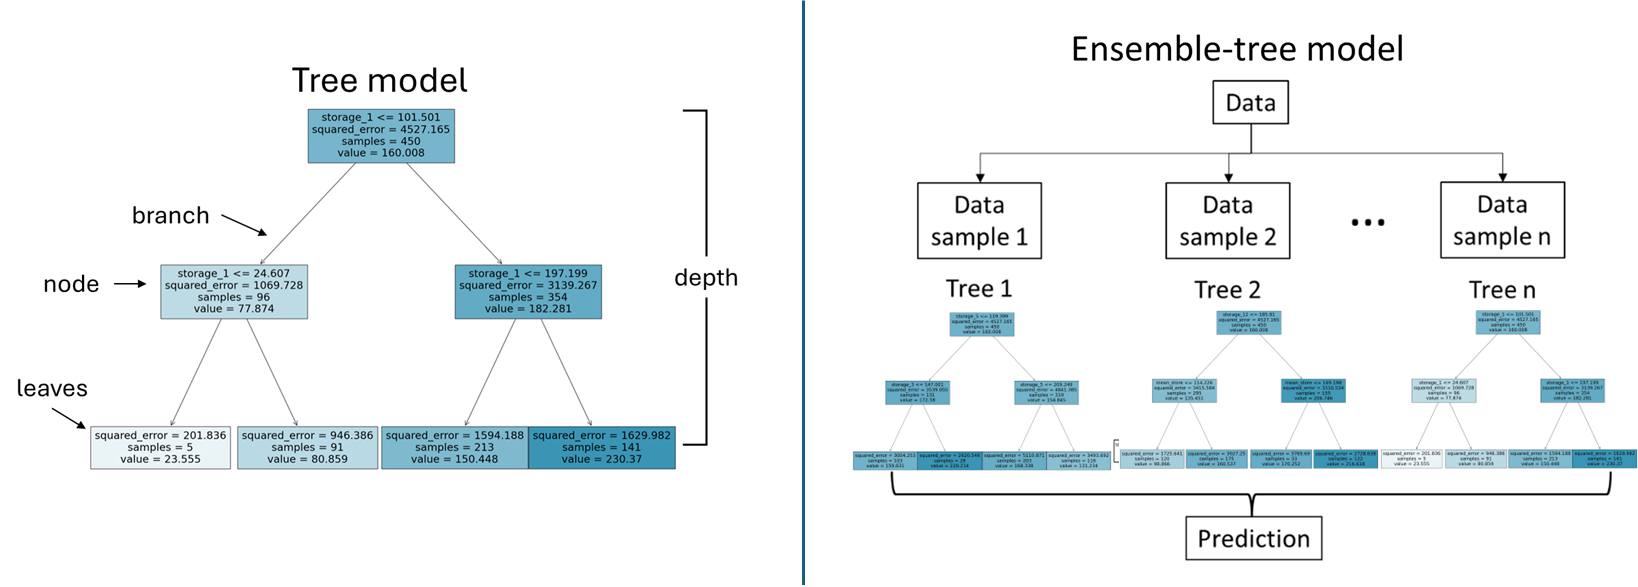

In the code below, try changing the hyperparameters and seeing what impact they have on the model performance.

In [ ]:
# vary the hyperparameters
n_trees = 200
max_depth = 4
max_features = 7
bootstrap = True
min_samples_leaf = 3
min_samples_split = 7

# train the model with new hyperparameters and full feature set (nb, if no hyperparameters are input then default values are used)
model_HT = RandomForestRegressor(random_state=345, n_estimators=n_trees ,max_depth=max_depth, bootstrap=bootstrap, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, max_features=max_features)
model_HT.fit(training_X,training_y)

# compare the new and old model predictions for the training and validation data, against a benchmark persistence model
runs = {
    'New Model train': (model_HT.predict(training_X), training_y),
    'New Model validate': (model_HT.predict(validation_X), validation_y),
    'Model train': (model.predict(training_X), training_y),
    'Model validate': (model.predict(validation_X), validation_y),
    'Benchmark train': (training_X['storage1'], training_y),
    'Benchmark validate': (validation_X['storage1'], validation_y)
}
df_results = (pd.DataFrame.from_dict(
          {name: eval_reses(obs, pred) for name, (obs, pred) in runs.items()}
          ))

# print the results
df_results.round(3)

Below, you can test different hyperparameters for a model trained on your preferred set of features (as found during feature selection), to produce your best performing (and least prone to overfitting!) model. Save your final figure to share with the group.

In [ ]:
# vary the hyperparameters
n_trees = 200
max_depth = 4
max_features = 7
bootstrap = True
min_samples_leaf = 3
min_samples_split = 7

# train the model with new hyperparameters and full feature set (nb, if no hyperparameters are input then default values are used)
model_fin = RandomForestRegressor(random_state=345, n_estimators=n_trees ,max_depth=max_depth, bootstrap=bootstrap, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, max_features=max_features)
model_fin.fit(training_FS_X,training_FS_y)

# compare the new and old model predictions for the training and validation data, against a benchmark persistence model
runs = {
    'New Model train': (model_HT.predict(training_FS_X), training_FS_y),
    'New Model validate': (model_HT.predict(validation_FS_X), validation_FS_y),
    'Model train': (model.predict(training_X), training_y),
    'Model validate': (model.predict(validation_X), validation_y),
    'Benchmark train': (training_X['storage1'], training_y),
    'Benchmark validate': (validation_X['storage1'], validation_y)
}
df_results = (pd.DataFrame.from_dict(
          {name: eval_reses(obs, pred) for name, (obs, pred) in runs.items()}
          ))

# print the results
df_results.round(3)

In [ ]:
# plotting the new results against the original model
obs = validation_y
x_axis = obs.index
pred_o = model.predict(validation_X)
pred_n = model_FS.predict(validation_FS_X)

fig, ax = plt.subplots(figsize=(6,3))
plt.plot(x_axis, obs, label='observed')
plt.plot(x_axis, pred_o, linestyle='--', label='original model')
plt.plot(x_axis, pred_n, linestyle=':', label='new model')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel(r'storage (%)',fontsize=13)
plt.xlabel('')
#plt.savefig('validation_FS.png', dpi=100,bbox_inches='tight') #un-comment this line if you want to save the plot to file
plt.show()

🤔**Questions**

 - What had more impact on model performance, feature selection or hyperparameter tuning?

 - What trends did you notice in the hyperparameter tuning?

 - What are the dangers of overfitting?